In [2]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

Saving snuh_alsfrs.csv to snuh_alsfrs.csv
Saving snuh_cr_cleaned.csv to snuh_cr_cleaned.csv
Saving snuh_dx.csv to snuh_dx.csv
Saving snuh_fvc.csv to snuh_fvc.csv
Saving snuh_gastro.csv to snuh_gastro.csv
Saving snuh_wt.csv to snuh_wt.csv


In [5]:
# import raw data
import io
static = pd.read_csv(io.BytesIO(uploaded['snuh_dx.csv']))
creatinine = pd.read_csv(io.BytesIO(uploaded['snuh_cr_cleaned.csv']))
weight = pd.read_csv(io.BytesIO(uploaded['snuh_wt.csv']))
alsfrs_R_raw = pd.read_csv(io.BytesIO(uploaded['snuh_alsfrs.csv']))
fvc = pd.read_csv(io.BytesIO(uploaded['snuh_fvc.csv']))
gastro = pd.read_csv(io.BytesIO(uploaded['snuh_gastro.csv']))

# 1. Extracting feature variables

## 1-1. Static features

### (1) Age/Gender (Demographics)

In [6]:
static.columns

Index(['Study_ID', 'Sex', 'Age_dx', 'Date_onset', 'Date_dx', 'Date_enrollment',
       'Onset_region'],
      dtype='object')

In [7]:
static.columns = ['SubjectID', 'Gender', 'Age', 'Date_onset', 'Date_dx',
       'Date_enrollment', 'Onset_region']
static = static.sort_values(by=['SubjectID'], axis=0).reset_index().drop(columns='index')
static

,SubjectID,Gender,Age,Date_onset,Date_dx,Date_enrollment,Onset_region
0,1003,F,65,2016-01-01,2017-03-01,2017-04-13,C
1,1005,M,31,2016-12-01,2017-03-01,2017-04-17,C
2,1017,F,72,2016-10-01,2017-04-01,2017-04-24,B
3,1019,F,61,2015-12-01,2016-12-01,2017-04-24,C
4,1020,F,56,2015-07-01,2017-04-01,2017-04-26,LS
...,...,...,...,...,...,...,...
228,1657,M,38,2021-01-30,2021-01-01,2021-04-14,LS
229,1659,M,61,2020-07-01,2020-03-01,2021-04-19,C
230,1722,M,49,2020-06-01,2020-08-01,2021-03-22,C
231,11871,M,61,2017-01-01,2017-11-01,2017-12-27,B


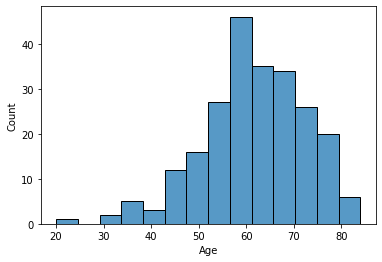

In [8]:
sns.histplot(static['Age']) 

In [9]:
static['Age'].describe() # min = 20, max = 84

count    233.000000
mean      61.596567
std       10.954073
min       20.000000
25%       55.000000
50%       63.000000
75%       70.000000
max       84.000000
Name: Age, dtype: float64

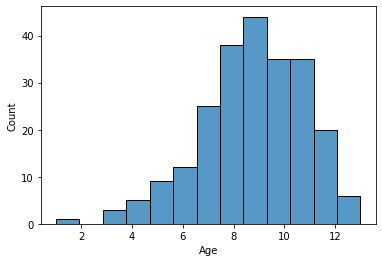

In [10]:
# Convert 'Age' into ordered-categorical data (categorize in  5 years)
age_min = 15 

def cat_age(age, age_min):
  return (age - age_min) // 5

static['Age'] = static.apply(lambda x: cat_age(x['Age'], age_min), axis = 1)
sns.histplot(static['Age'])

In [11]:
# Female = 0, Male = 1
static = static.replace({'Gender':{"F":0, "M":1}})
static #233 data

,SubjectID,Gender,Age,Date_onset,Date_dx,Date_enrollment,Onset_region
0,1003,0,10,2016-01-01,2017-03-01,2017-04-13,C
1,1005,1,3,2016-12-01,2017-03-01,2017-04-17,C
2,1017,0,11,2016-10-01,2017-04-01,2017-04-24,B
3,1019,0,9,2015-12-01,2016-12-01,2017-04-24,C
4,1020,0,8,2015-07-01,2017-04-01,2017-04-26,LS
...,...,...,...,...,...,...,...
228,1657,1,4,2021-01-30,2021-01-01,2021-04-14,LS
229,1659,1,9,2020-07-01,2020-03-01,2021-04-19,C
230,1722,1,6,2020-06-01,2020-08-01,2021-03-22,C
231,11871,1,9,2017-01-01,2017-11-01,2017-12-27,B


### (2) diag_delta/onset_delta/diag_minus_onset/onset_site (ALS history)

In [12]:
# Calculate onset_delta, diag_delta, diag_minus_onset in months 
static['onset_delta'] = (pd.to_datetime(static['Date_onset'])- pd.to_datetime(static['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365
static['diag_delta'] = (pd.to_datetime(static['Date_dx'])- pd.to_datetime(static['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365
static['diag_minus_onset'] = static['diag_delta']-static['onset_delta'] #define 'diag_minus_onset' as time difference between onset and diagnosis

# Save Data_enrollment (for feature delata calculation in time-resolved feature) 
date_enroll = static[['SubjectID', 'Date_enrollment']]
static.drop(columns = ['Date_onset','Date_enrollment','Date_dx'], inplace = True)

# Bubar_onset = 1, non-Bulbar_onset = 0
static.rename(columns = {'Onset_region':'onset_site'}, inplace = True)
static = static.replace({'onset_site':{"LS":0, "B":1, "C":0, "BL":1}})

static #233 data

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset
0,1003,0,10,0,-15.386301,-1.413699,13.972603
1,1005,1,3,0,-4.504110,-1.545205,2.958904
2,1017,0,11,1,-6.739726,-0.756164,5.983562
3,1019,0,9,0,-16.767123,-4.734247,12.032877
4,1020,0,8,0,-21.863014,-0.821918,21.041096
...,...,...,...,...,...,...,...
228,1657,1,4,0,-2.432877,-3.386301,-0.953425
229,1659,1,9,0,-9.600000,-13.610959,-4.010959
230,1722,1,6,0,-9.665753,-7.660274,2.005479
231,11871,1,9,1,-11.835616,-1.841096,9.994521


In [13]:
static[static['diag_minus_onset']<0]

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset
118,1422,0,12,1,2.663014,-1.380822,-4.043836
125,1436,1,11,1,-4.306849,-11.276712,-6.969863
228,1657,1,4,0,-2.432877,-3.386301,-0.953425
229,1659,1,9,0,-9.600000,-13.610959,-4.010959


In [14]:
static = static.query('diag_minus_onset >= 0')
static

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset
0,1003,0,10,0,-15.386301,-1.413699,13.972603
1,1005,1,3,0,-4.504110,-1.545205,2.958904
2,1017,0,11,1,-6.739726,-0.756164,5.983562
3,1019,0,9,0,-16.767123,-4.734247,12.032877
4,1020,0,8,0,-21.863014,-0.821918,21.041096
...,...,...,...,...,...,...,...
226,1654,1,7,0,-8.909589,-3.879452,5.030137
227,1655,1,8,1,-12.164384,-1.183562,10.980822
230,1722,1,6,0,-9.665753,-7.660274,2.005479
231,11871,1,9,1,-11.835616,-1.841096,9.994521


## 1-2. Time-resolved features

### (0) Define function

In [15]:
# Define function returning df with calculated feature delta for time-resolved feautures 
def cal_feature_delta(df, date_enroll):
  df1 = pd.merge(df, date_enroll)
  df1['feature_delta'] = (pd.to_datetime(df1['Date_visit'])- pd.to_datetime(df1['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365
  df1 = df1.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
  df1.drop(columns = ['Date_visit','Date_enrollment'], inplace = True)
  return df1

In [16]:
# Define function drawing histplot of first, second delta of each SubjectID 
def hisplot_first_second_delta(df):
  df_delta = df[['SubjectID', 'feature_delta']]
  df1 = df_delta.groupby('SubjectID').nth(0)
  df1.columns = ['first delta'] 
  plt.figure(figsize=(15,5))
  plt.subplot(121)
  sns.histplot(df1)

  df2 = df_delta.groupby('SubjectID').nth(1)
  df2.columns = ['second delta'] 
  plt.subplot(122)
  sns.histplot(df2)

In [17]:
# Define function calculating mean
def cal_mean(df):
  df_mean = df.groupby('SubjectID').agg('mean')
  df_mean.reset_index(inplace=True) # reset 'SubjectiD' as column
  
  mean_df = pd.DataFrame(df_mean['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    mean_df['mean_'+feature] = df_mean[feature]

  return mean_df

In [18]:
# Define function calculating slope
def cal_slope(df):
  df_first_last = df.groupby('SubjectID').agg(['first', 'last'])
  df_first_last.reset_index(inplace=True) # reset 'SubjectiD' as column
  df_first_last['interval'] = df_first_last[('feature_delta','last')] - df_first_last[('feature_delta','first')]
  df_first_last = df_first_last[df_first_last['interval']!=0] # exclude data that is observed only once

  slope_df = pd.DataFrame(df_first_last['SubjectID'])
  feature_list = list(df.drop(columns = ['SubjectID', 'feature_delta']).columns)

  for feature in feature_list:
    slope_df['slope_'+feature] = df_first_last.apply(lambda x: (x[(feature,'last')]-x[(feature, 'first')])/x[('interval','')] if x[('interval','')] >= 1.0 else np.nan, axis = 1)
    # data with time interval less than 1 month is regarded as missing data, otherwise calculate slope with data of (last, first) feature delta

  return slope_df

In [19]:
# Define function calculating for time-resolved features
def cal_time_resolved(df):
  # Filter first 3 month data
  df_3mo = df.query('(feature_delta <= 3.0) and (feature_delta >= 0)')

  # Calculate mean
  mean_df = cal_mean(df_3mo)

  # Calculate slope
  slope_df = cal_slope(df_3mo)
  
  # Merge mean & slope data
  df_summary =  mean_df.merge(slope_df, on = 'SubjectID', how='outer')

  return df_summary

### (1) alsfrs_r (total/3 dimension/q)

In [21]:
alsfrs_R_raw1 = alsfrs_R_raw.drop(columns = ['gastrostomy'])

# Add alsfrs-3dimension scores 
alsfrs_R_raw1['bulbar'] = alsfrs_R_raw1['Q1']+alsfrs_R_raw1['Q3']
alsfrs_R_raw1['motor'] = alsfrs_R_raw1['Q4']+alsfrs_R_raw1['Q5']+alsfrs_R_raw1['Q6']+alsfrs_R_raw1['Q7']+alsfrs_R_raw1['Q8']+alsfrs_R_raw1['Q9']
alsfrs_R_raw1['respiratory'] = alsfrs_R_raw1['Q10']+alsfrs_R_raw1['Q11']+alsfrs_R_raw1['Q12']

# Reset column name
alsfrs_R_raw1.columns = ['SubjectID', 'Date_visit', 'ALSFRS_R_Total', 'Q1_Speech',
       'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5_Cutting',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea',
       'R3_Respiratory_Insufficiency', 'bulbar', 'motor', 'respiratory']

# Calculate feature delta 
alsfrs_R_raw1 = cal_feature_delta(alsfrs_R_raw1, date_enroll) 

# Calculate summary
alsfrs_R_summary = cal_time_resolved(alsfrs_R_raw1)
alsfrs_R_summary #227 data

,SubjectID,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory
0,1005,33.0,4.0,4.0,4.0,1.0,2.0,1.0,1.0,3.0,1.0,4.0,4.0,4.0,8.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1017,31.5,2.5,3.0,3.0,2.5,2.5,2.0,2.0,2.5,1.5,2.5,3.5,4.0,5.5,13.0,10.0,-1.382576,-0.460859,-0.921717,0.000000,0.460859,0.460859,0.000000,0.921717,-0.460859,0.460859,-1.382576,-0.460859,0.0,-0.460859,1.843434,-1.843434
2,1019,40.5,4.0,4.0,3.5,3.0,4.0,2.5,3.0,3.0,1.5,4.0,4.0,4.0,7.5,17.0,12.0,-1.002747,0.000000,0.000000,-0.334249,0.000000,0.000000,-0.334249,0.000000,0.000000,-0.334249,0.000000,0.000000,0.0,-0.334249,-0.668498,0.000000
3,1020,35.0,4.0,4.0,4.0,3.5,3.0,2.0,2.0,1.0,0.5,3.0,4.0,4.0,8.0,12.0,11.0,-3.417603,0.000000,0.000000,0.000000,-0.341760,0.000000,-0.683521,-0.683521,-0.683521,-0.341760,-0.683521,0.000000,0.0,0.000000,-2.734082,-0.683521
4,1021,45.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,8.0,21.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,1657,41.5,4.0,4.0,4.0,3.5,3.5,3.0,3.0,2.5,2.0,4.0,4.0,4.0,8.0,17.5,12.0,-2.236520,0.000000,0.000000,0.000000,-0.447304,-0.447304,0.000000,0.000000,-0.447304,-0.894608,0.000000,0.000000,0.0,0.000000,-2.236520,0.000000
223,1659,42.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,8.0,18.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,1722,41.5,4.0,4.0,3.5,2.0,3.0,3.0,3.0,3.5,3.5,4.0,4.0,4.0,7.5,18.0,12.0,-1.185065,0.000000,0.000000,-0.395022,0.000000,0.000000,0.000000,0.000000,-0.395022,-0.395022,0.000000,0.000000,0.0,-0.395022,-0.790043,0.000000
225,11871,37.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,6.0,16.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


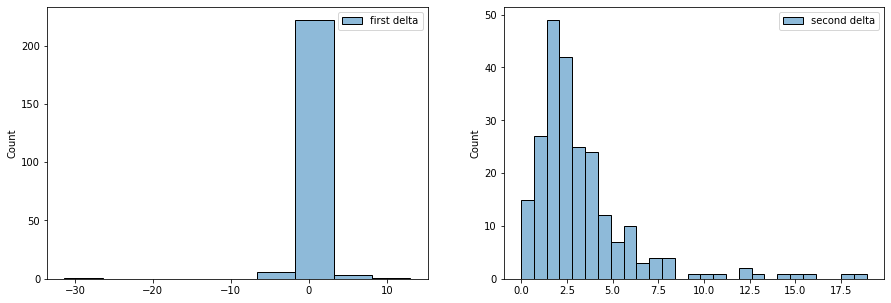

In [22]:
hisplot_first_second_delta(alsfrs_R_raw1)

### (2) FVC

In [24]:
fvc1 = fvc.copy()

# Reset column name
fvc1.columns = ['SubjectID', 'Date_visit', 'fvc']

# Calculate feature delta 
fvc1 = cal_feature_delta(fvc1, date_enroll) 

# Calculate summary
fvc_summary = cal_time_resolved(fvc1)
fvc_summary # 138 data

,SubjectID,mean_fvc,slope_fvc
0,1003,91.0,NaN
1,1005,77.0,NaN
2,1017,46.5,-1.382576
3,1019,77.0,NaN
4,1020,75.0,NaN
...,...,...,...
133,1636,121.0,NaN
134,1650,79.0,NaN
135,1722,89.0,NaN
136,11871,96.0,NaN


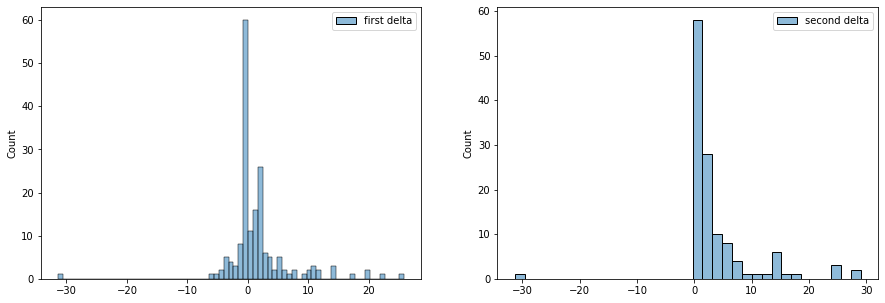

In [25]:
hisplot_first_second_delta(fvc1)

### (3) Creatinine

In [26]:
creatinine

,Study_ID,Date,Cr
0,11872,2017-12-17,0.69
1,11871,2017-12-26,0.88
2,11871,2018-01-08,0.94
3,11871,2018-01-02,0.85
4,1657,2021-05-02,0.79
...,...,...,...
1041,1005,2020-01-27,0.50
1042,1005,2020-01-22,0.43
1043,1005,2020-02-10,0.44
1044,1003,2017-03-09,0.53


In [28]:
creatinine1 = creatinine.copy()

# Reset column name
creatinine1.columns = ['SubjectID', 'Date_visit', 'Creatinine']

# Calculate feature delta 
creatinine1 = cal_feature_delta(creatinine1, date_enroll) 

# Calculate summary
creatinine_summary = cal_time_resolved(creatinine1)
creatinine_summary # 129 data

,SubjectID,mean_Creatinine,slope_Creatinine
0,1005,80.666667,-8.690476
1,1017,62.000000,NaN
2,1021,52.000000,-2.172619
3,1030,76.000000,NaN
4,1031,76.600000,4.345238
...,...,...,...
124,1639,61.000000,NaN
125,1642,82.000000,NaN
126,1657,79.000000,NaN
127,11871,89.500000,NaN


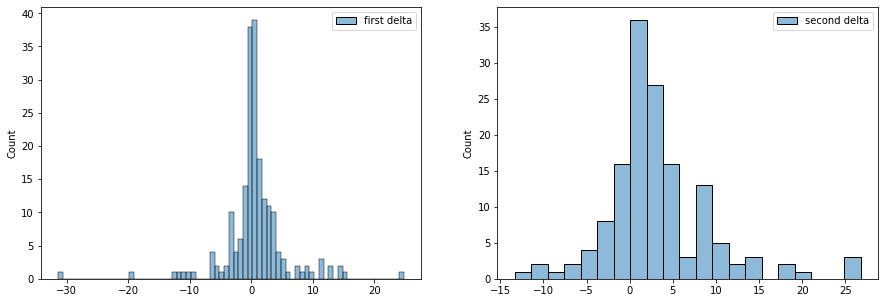

In [29]:
hisplot_first_second_delta(creatinine1)

### (4) Weight

In [31]:
weight1 = weight.copy()

# Reset column name
weight1.columns = ['SubjectID', 'Date_visit', 'weight']

# Calculate feature delta 
weight1 = cal_feature_delta(weight1, date_enroll) 

# Calculate summary
weight_summary = cal_time_resolved(weight1)
weight_summary # 228 data

,SubjectID,mean_weight,slope_weight
0,1003,62.0,0.000000
1,1005,69.0,0.000000
2,1017,51.5,-1.382576
3,1019,56.0,0.000000
4,1020,47.5,0.341760
...,...,...,...
223,1655,85.0,0.000000
224,1657,79.0,-0.894608
225,1659,57.0,0.000000
226,1722,69.0,NaN


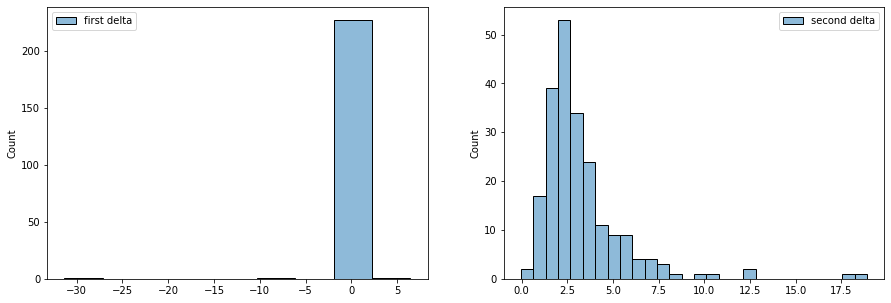

In [32]:
hisplot_first_second_delta(weight1)

## 1-3. Merging all features

In [33]:
features_without_alsfrs = pd.DataFrame(columns=['SubjectID'])
feature_list = [static, fvc_summary, creatinine_summary, weight_summary]
for i in feature_list :
    df = i
    features_without_alsfrs = features_without_alsfrs.merge(df, on='SubjectID', how='outer')
features_without_alsfrs.query('diag_minus_onset >=0', inplace=True) 
features_without_alsfrs #229 data 

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight
0,1003,0.0,10.0,0.0,-15.386301,-1.413699,13.972603,91.0,NaN,NaN,NaN,62.0,0.000000
1,1005,1.0,3.0,0.0,-4.504110,-1.545205,2.958904,77.0,NaN,80.666667,-8.690476,69.0,0.000000
2,1017,0.0,11.0,1.0,-6.739726,-0.756164,5.983562,46.5,-1.382576,62.000000,NaN,51.5,-1.382576
3,1019,0.0,9.0,0.0,-16.767123,-4.734247,12.032877,77.0,NaN,NaN,NaN,56.0,0.000000
4,1020,0.0,8.0,0.0,-21.863014,-0.821918,21.041096,75.0,NaN,NaN,NaN,47.5,0.341760
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,1654,1.0,7.0,0.0,-8.909589,-3.879452,5.030137,NaN,NaN,NaN,NaN,62.0,NaN
225,1655,1.0,8.0,1.0,-12.164384,-1.183562,10.980822,NaN,NaN,NaN,NaN,85.0,0.000000
226,1722,1.0,6.0,0.0,-9.665753,-7.660274,2.005479,89.0,NaN,NaN,NaN,69.0,NaN
227,11871,1.0,9.0,1.0,-11.835616,-1.841096,9.994521,96.0,NaN,89.500000,NaN,NaN,NaN


In [34]:
# features_with_alsfrs_R
features_with_alsfrs_R = features_without_alsfrs.merge(alsfrs_R_summary, on='SubjectID', how = 'inner')
features_with_alsfrs_R #223 data

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_fvc,slope_fvc,mean_Creatinine,slope_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory
0,1005,1.0,3.0,0.0,-4.504110,-1.545205,2.958904,77.0,NaN,80.666667,-8.690476,69.0,0.000000,33.0,4.0,4.0,4.0,1.0,2.0,1.0,1.0,3.0,1.0,4.0,4.0,4.0,8.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1017,0.0,11.0,1.0,-6.739726,-0.756164,5.983562,46.5,-1.382576,62.000000,NaN,51.5,-1.382576,31.5,2.5,3.0,3.0,2.5,2.5,2.0,2.0,2.5,1.5,2.5,3.5,4.0,5.5,13.0,10.0,-1.382576,-0.460859,-0.921717,0.000000,0.460859,0.460859,0.000000,0.921717,-0.460859,0.460859,-1.382576,-0.460859,0.0,-0.460859,1.843434,-1.843434
2,1019,0.0,9.0,0.0,-16.767123,-4.734247,12.032877,77.0,NaN,NaN,NaN,56.0,0.000000,40.5,4.0,4.0,3.5,3.0,4.0,2.5,3.0,3.0,1.5,4.0,4.0,4.0,7.5,17.0,12.0,-1.002747,0.000000,0.000000,-0.334249,0.000000,0.000000,-0.334249,0.000000,0.000000,-0.334249,0.000000,0.000000,0.0,-0.334249,-0.668498,0.000000
3,1020,0.0,8.0,0.0,-21.863014,-0.821918,21.041096,75.0,NaN,NaN,NaN,47.5,0.341760,35.0,4.0,4.0,4.0,3.5,3.0,2.0,2.0,1.0,0.5,3.0,4.0,4.0,8.0,12.0,11.0,-3.417603,0.000000,0.000000,0.000000,-0.341760,0.000000,-0.683521,-0.683521,-0.683521,-0.341760,-0.683521,0.000000,0.0,0.000000,-2.734082,-0.683521
4,1021,0.0,5.0,0.0,-25.906849,-0.854795,25.052055,NaN,NaN,52.000000,-2.172619,75.0,NaN,45.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,8.0,21.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,1654,1.0,7.0,0.0,-8.909589,-3.879452,5.030137,NaN,NaN,NaN,NaN,62.0,NaN,46.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,8.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,1655,1.0,8.0,1.0,-12.164384,-1.183562,10.980822,NaN,NaN,NaN,NaN,85.0,0.000000,45.0,2.5,3.5,3.5,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.5,4.0,6.0,24.0,11.5,0.000000,-0.440821,0.440821,0.440821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.440821,0.0,0.000000,0.000000,-0.440821
220,1722,1.0,6.0,0.0,-9.665753,-7.660274,2.005479,89.0,NaN,NaN,NaN,69.0,NaN,41.5,4.0,4.0,3.5,2.0,3.0,3.0,3.0,3.5,3.5,4.0,4.0,4.0,7.5,18.0,12.0,-1.185065,0.000000,0.000000,-0.395022,0.000000,0.000000,0.000000,0.000000,-0.395022,-0.395022,0.000000,0.000000,0.0,-0.395022,-0.790043,0.000000
221,11871,1.0,9.0,1.0,-11.835616,-1.841096,9.994521,96.0,NaN,89.500000,NaN,NaN,NaN,37.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,6.0,16.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1-4. Check NaN proportion 

### (1) Check NaN proportion in features for train/test data

The column mean_fvc has 90 null values. It is 40.36% of total rows.
The column mean_fvc is of type float64.

The column slope_fvc has 200 null values. It is 89.69% of total rows.
The column slope_fvc is of type float64.

The column mean_Creatinine has 99 null values. It is 44.39% of total rows.
The column mean_Creatinine is of type float64.

The column slope_Creatinine has 194 null values. It is 87.0% of total rows.
The column slope_Creatinine is of type float64.

The column mean_weight has 5 null values. It is 2.24% of total rows.
The column mean_weight is of type float64.

The column slope_weight has 98 null values. It is 43.95% of total rows.
The column slope_weight is of type float64.

The column slope_ALSFRS_R_Total has 95 null values. It is 42.6% of total rows.
The column slope_ALSFRS_R_Total is of type float64.

The column slope_Q1_Speech has 95 null values. It is 42.6% of total rows.
The column slope_Q1_Speech is of type float64.

The column slope_Q2_Salivation has 95 null valu

['slope_fvc', 'slope_Creatinine']

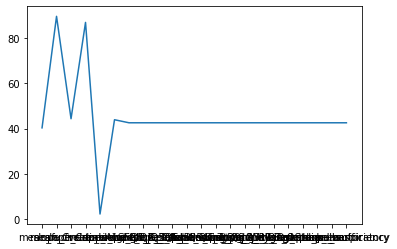

In [35]:
def report_nulls(df):
    '''
    Show a fast report of the DF.
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    null_cols = 0
    list_of_nulls_cols = []
    list_of_nulls_cols_pcn = []
    list_of_nulls_cols_over60 = []
    for col in list(df.columns):
        null_values_rows = df[col].isnull().sum()
        null_rows_pcn = round(((null_values_rows)/rows)*100, 2)
        col_type = df[col].dtype
        if null_values_rows > 0:
            print("The column {} has {} null values. It is {}% of total rows.".format(col, null_values_rows, null_rows_pcn))
            print("The column {} is of type {}.\n".format(col, col_type))
            null_cols += 1
            list_of_nulls_cols.append(col)
            list_of_nulls_cols_pcn.append(null_rows_pcn)
            if null_rows_pcn > 60:
                list_of_nulls_cols_over60.append(col)
    null_cols_pcn = round((null_cols/columns)*100, 2)
    print("The DataFrame has {} columns with null values. It is {}% of total columns.".format(null_cols, null_cols_pcn))
    plt.plot(list_of_nulls_cols, list_of_nulls_cols_pcn)
    return list_of_nulls_cols_over60

report_nulls(features_with_alsfrs_R) # {onset_delta / diag_delta / diag_minus_onset}-> 54.77%  {onset_site}-> 54.78%  {mean_alsfrs_q} -> 33.93%  {slope_alsfrs_q} -> 42.55%  of Total 9848 data

In [36]:
features_with_alsfrs_R.isnull().sum()

SubjectID                               0
Gender                                  0
Age                                     0
onset_site                              0
onset_delta                             0
diag_delta                              0
diag_minus_onset                        0
mean_fvc                               90
slope_fvc                             200
mean_Creatinine                        99
slope_Creatinine                      194
mean_weight                             5
slope_weight                           98
mean_ALSFRS_R_Total                     0
mean_Q1_Speech                          0
mean_Q2_Salivation                      0
mean_Q3_Swallowing                      0
mean_Q4_Handwriting                     0
mean_Q5_Cutting                         0
mean_Q6_Dressing_and_Hygiene            0
mean_Q7_Turning_in_Bed                  0
mean_Q8_Walking                         0
mean_Q9_Climbing_Stairs                 0
mean_R1_Dyspnea                   

In [37]:
#Create df for showing NaN pattern
feature_nan_pattern1 = features_with_alsfrs_R[['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_Q1_Speech','slope_Q1_Speech', 'mean_fvc', 'slope_fvc', 'mean_Creatinine',
       'slope_Creatinine', 'mean_weight','slope_weight']]
feature_nan_pattern1.columns = ['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_ALSFRS','slope_ALSFRS', 'mean_fvc', 'slope_fvc', 'mean_Creatinine',
       'slope_Creatinine', 'mean_weight','slope_weight']

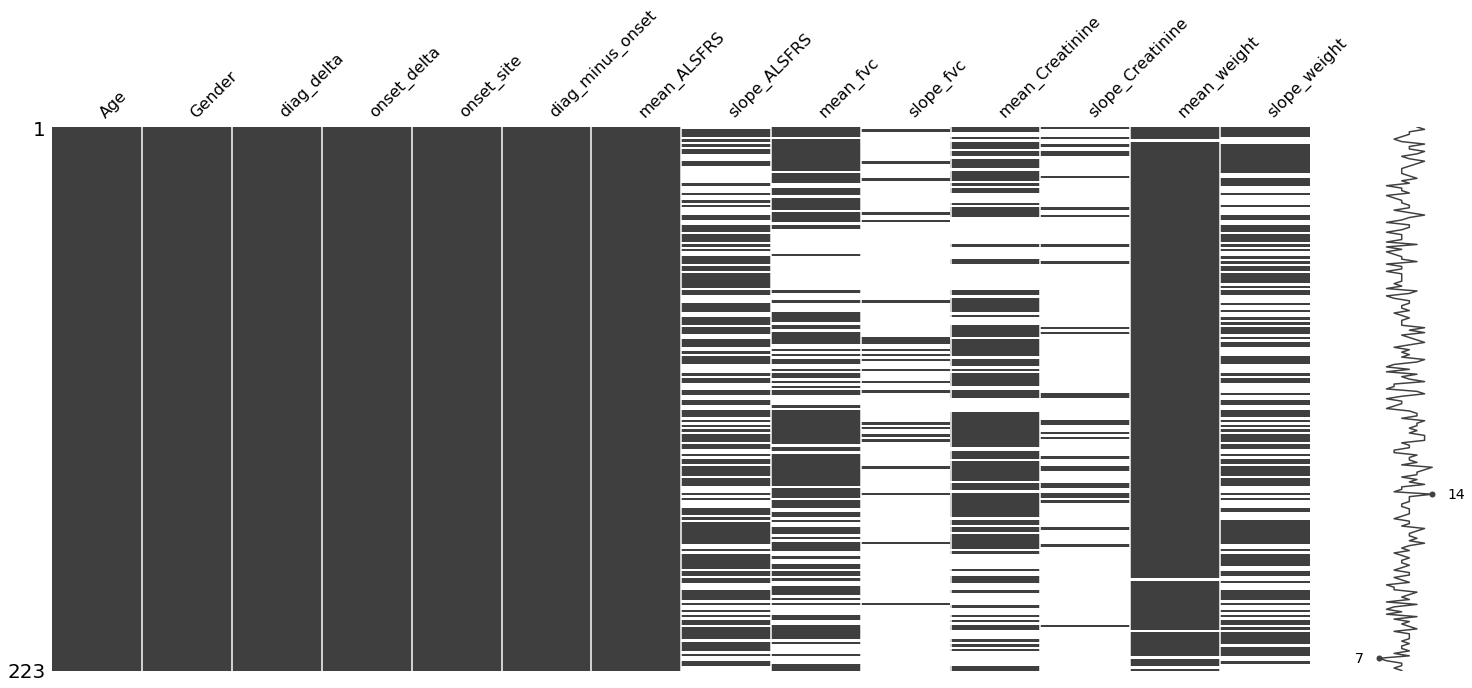

In [38]:
# Nullity matrix
import missingno as msno
msno.matrix(feature_nan_pattern1)

In [39]:
# Exclude 'slope_fvc' in feature list because it's NaN proportion is over 50% & it can be replaced by alsfrs respiratory score
features_snuh = features_with_alsfrs_R.drop(columns = ['slope_fvc', 'slope_Creatinine'])

In [40]:
features_snuh.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/0227/0227_X_NaN_snuh.csv')

In [47]:
features_snuh

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory
0,1005,1.0,3.0,0.0,-4.504110,-1.545205,2.958904,77.0,80.666667,69.0,0.000000,33.0,4.0,4.0,4.0,1.0,2.0,1.0,1.0,3.0,1.0,4.0,4.0,4.0,8.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1017,0.0,11.0,1.0,-6.739726,-0.756164,5.983562,46.5,62.000000,51.5,-1.382576,31.5,2.5,3.0,3.0,2.5,2.5,2.0,2.0,2.5,1.5,2.5,3.5,4.0,5.5,13.0,10.0,-1.382576,-0.460859,-0.921717,0.000000,0.460859,0.460859,0.000000,0.921717,-0.460859,0.460859,-1.382576,-0.460859,0.0,-0.460859,1.843434,-1.843434
2,1019,0.0,9.0,0.0,-16.767123,-4.734247,12.032877,77.0,NaN,56.0,0.000000,40.5,4.0,4.0,3.5,3.0,4.0,2.5,3.0,3.0,1.5,4.0,4.0,4.0,7.5,17.0,12.0,-1.002747,0.000000,0.000000,-0.334249,0.000000,0.000000,-0.334249,0.000000,0.000000,-0.334249,0.000000,0.000000,0.0,-0.334249,-0.668498,0.000000
3,1020,0.0,8.0,0.0,-21.863014,-0.821918,21.041096,75.0,NaN,47.5,0.341760,35.0,4.0,4.0,4.0,3.5,3.0,2.0,2.0,1.0,0.5,3.0,4.0,4.0,8.0,12.0,11.0,-3.417603,0.000000,0.000000,0.000000,-0.341760,0.000000,-0.683521,-0.683521,-0.683521,-0.341760,-0.683521,0.000000,0.0,0.000000,-2.734082,-0.683521
4,1021,0.0,5.0,0.0,-25.906849,-0.854795,25.052055,NaN,52.000000,75.0,NaN,45.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,8.0,21.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,1654,1.0,7.0,0.0,-8.909589,-3.879452,5.030137,NaN,NaN,62.0,NaN,46.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,8.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,1655,1.0,8.0,1.0,-12.164384,-1.183562,10.980822,NaN,NaN,85.0,0.000000,45.0,2.5,3.5,3.5,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.5,4.0,6.0,24.0,11.5,0.000000,-0.440821,0.440821,0.440821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.440821,0.0,0.000000,0.000000,-0.440821
220,1722,1.0,6.0,0.0,-9.665753,-7.660274,2.005479,89.0,NaN,69.0,NaN,41.5,4.0,4.0,3.5,2.0,3.0,3.0,3.0,3.5,3.5,4.0,4.0,4.0,7.5,18.0,12.0,-1.185065,0.000000,0.000000,-0.395022,0.000000,0.000000,0.000000,0.000000,-0.395022,-0.395022,0.000000,0.000000,0.0,-0.395022,-0.790043,0.000000
221,11871,1.0,9.0,1.0,-11.835616,-1.841096,9.994521,96.0,89.500000,NaN,NaN,37.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,6.0,16.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
subjects_with_feature = list(features_snuh['SubjectID'])

# 2. Extracting target variables

## 2-1. Optimal target (Q3 becoming 1.0)

In [ ]:
# FVC 기준 삭제

### (1) Subtracting [initial Q3 score <=1 ]

In [49]:
alsfrs_Sw = alsfrs_R_raw1[['SubjectID', 'Q3_Swallowing', 'feature_delta']]
alsfrs_Sw = alsfrs_Sw.query("SubjectID == {0}".format(subjects_with_feature))
alsfrs_Sw = alsfrs_Sw[alsfrs_Sw['feature_delta']>=0]
alsfrs_Sw 

,SubjectID,Q3_Swallowing,feature_delta
4,1005,4,0.920548
5,1005,4,7.134247
6,1005,3,11.046575
7,1005,4,13.808219
8,1005,4,16.339726
...,...,...,...
1078,11872,4,0.000000
1079,11872,4,4.109589
1080,11872,4,5.950685
1081,11872,4,10.323288


In [50]:
alsfrs_Sw_grouped = alsfrs_Sw.groupby('SubjectID').agg(['first', 'last'])
alsfrs_Sw_grouped = alsfrs_Sw_grouped.reset_index()
alsfrs_Sw_grouped = alsfrs_Sw_grouped[alsfrs_Sw_grouped[('feature_delta', 'last')]!= alsfrs_Sw_grouped[('feature_delta', 'first')]] # more than 2 observation needed (score chagnes from above 2 to 2)
alsfrs_filtered_extent = list(alsfrs_Sw_grouped[alsfrs_Sw_grouped[('Q3_Swallowing','first')]>1.0].reset_index()['SubjectID']) # initial ALSFRS Q3 > 1

In [51]:
# Subtract [first ALSFRS Q3 <=1.0] & [ALSFRS Q3 observed only once]
alsfrs_Sw_filtered = alsfrs_Sw.query("SubjectID == {0}".format(alsfrs_filtered_extent))
alsfrs_Sw_filtered

,SubjectID,Q3_Swallowing,feature_delta
4,1005,4,0.920548
5,1005,4,7.134247
6,1005,3,11.046575
7,1005,4,13.808219
8,1005,4,16.339726
...,...,...,...
1078,11872,4,0.000000
1079,11872,4,4.109589
1080,11872,4,5.950685
1081,11872,4,10.323288


### (2) Time of [Q3 score == 1.0]

In [52]:
# Find the first time of [ALSFRS_Q3 <= 1.0]
Optimal_event = alsfrs_Sw_filtered[alsfrs_Sw_filtered['Q3_Swallowing']<=1].groupby('SubjectID').agg(['first']).reset_index()

In [53]:
# Coding [ALSFRS-Q3<=1] event as '1'
Optimal_event_1 = Optimal_event[[(    'SubjectID',      ''), ('feature_delta', 'first')]]
Optimal_event_1.columns = ['SubjectID', 'time_opt']

Optimal_event_1_sublist = list(Optimal_event['SubjectID'])

Optimal_event_1['status_opt'] = 1
print("There are",len(Optimal_event_1['SubjectID'].unique()), "subjects whose status_opt = 1")

# Otherwise '0'
Optimal_event_0 = alsfrs_Sw_filtered[~alsfrs_Sw_filtered['SubjectID'].isin(Optimal_event_1_sublist)]
Optimal_event_0 = Optimal_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=('Q3_Swallowing', 'last'))
Optimal_event_0.columns = ['SubjectID', 'time_opt']
Optimal_event_0['status_opt'] = 0
print("There are",len(Optimal_event_0['SubjectID'].unique()), "subjects whose status_opt = 0")
 # There are 27 subjects whose status_opt = 1
 # There are 194 subjects whose status_opt = 0

There are 27 subjects whose status_opt = 1
There are 194 subjects whose status_opt = 0


In [54]:
alsfrs_Sw_coded = pd.concat([Optimal_event_1, Optimal_event_0]).sort_values(by='SubjectID', axis=0)
alsfrs_Sw_coded = alsfrs_Sw_coded.reset_index()
alsfrs_Sw_coded.drop(columns='index', inplace=True)

Optimal_Gas = alsfrs_Sw_coded.copy()
sub_list = list(Optimal_Gas['SubjectID'])
Optimal_Gas #221 data

,SubjectID,time_opt,status_opt
0,1005,30.378082,1
1,1017,3.024658,0
2,1019,20.515068,0
3,1020,2.926027,0
4,1021,47.769863,0
...,...,...,...
216,1654,3.221918,0
217,1655,2.268493,0
218,1722,2.531507,0
219,11871,12.361644,0


In [55]:
Optimal_Gas.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/0227/0227_optimal_target_snuh.csv')

In [56]:
# Be aware that 'time_opt' is month scaled

## 2-2. Real target

### (0) Time of gastrostomy event 

In [59]:
gastro1 = gastro.drop(columns = ['Hosp_ID', 'Event'])

# Reset column name
gastro1.columns = ['SubjectID', 'Date_visit']

# Calculate feature delta 
gastro1 = cal_feature_delta(gastro1, date_enroll) 

gastro1.columns = ['SubjectID', 'time_real']
gastro1['status_real'] = 1
gastro1

,SubjectID,time_real,status_real
0,1019,27.419178,1
1,1021,38.005479,1
2,1029,6.608219,1
3,1046,29.786301,1
4,1058,16.339726,1
5,1063,2.465753,1
6,1111,5.260274,1
7,1115,16.208219,1
8,1117,32.054795,1
9,1124,4.931507,1


In [60]:
gastro1.to_csv('/content/drive/MyDrive/Colab Notebooks/본 실험/0227/0227_real_target_snuh_status1.csv')